# BFuzzer

Some magick before we get started.
* %top and %%top are magicks for line and cell respectively that can be used to disable the evaluation when the notebook is exported.
* %%var is used to extract contents of the cell to `$VARS` variable.

In [1]:
TOP = True

In [2]:
from IPython.core.magic import  (Magics, magics_class, cell_magic, line_magic, line_cell_magic)
class B(dict):
    def __getattr__(self, name):
        return self.__getitem__(name)
@magics_class
class MyMagics(Magics):
    def __init__(self, shell=None,  **kwargs):
        super().__init__(shell=shell, **kwargs)
        self._vars = B()
        shell.user_ns['VARS'] = self._vars

    @cell_magic
    def var(self, line, cell):
        self._vars[line.strip()] = cell.strip()
 
    @line_cell_magic
    def top(self, line, cell=None):
        if TOP:
            if cell is None:
                cell = line
            ip = get_ipython()
            res = ip.run_cell(cell)

get_ipython().register_magics(MyMagics)

This notebook has only been tested in the specific Python versions below.

In [3]:
import sys

In [4]:
%top assert sys.version_info[0:2] in [(3, 6)]

Jupyter has the bad habit of continuing the execution sometimes after an exception has happened. This variable tells us if any exception has happened until now.

In [5]:
EXCEPTION_HAPPENED = []

In [6]:
%top IP = get_ipython()

In [7]:
from IPython.core.ultratb import AutoFormattedTB
itb = AutoFormattedTB(mode = 'Plain', tb_offset = 1)
def custom_exc(shell, etype, evalue, tb, tb_offset=None):
    global EXCEPTION_HAPPENED
    EXCEPTION_HAPPENED.append(IP.last_execution_result.execution_count + 1)
    shell.showtraceback((etype, evalue, tb), tb_offset=tb_offset)

In [8]:
%top IP.set_custom_exc((Exception,), custom_exc)

## Do

Next, we define a wrapper for command execution.

In [9]:
import subprocess
import os
import json

The `do()` command executes and saves return code, stdin and stderr.

In [10]:
class O:
    def __init__(self, **keys): self.__dict__.update(keys)
    def __repr__(self): return str(self.__dict__)

In [11]:
def do(command, env=None, shell=False, log=False, **args):
    result = subprocess.Popen(command, stdout=subprocess.PIPE, stderr = subprocess.PIPE,
                              shell=shell,
                              env=dict(os.environ, **({} if env is None else env))
                             )
    stdout, stderr = result.communicate(timeout=10)
    os.makedirs('build', exist_ok=True)
    code = result.returncode
    ecode = ((256-code) * -1) if code > 127 else code
    if log:
        with open('build/do.log', 'a+') as f:
            print(json.dumps({'cmd':command, 'env':env, 'exitcode':ecode, 'ocode':code}), env, file=f)
    return O(cmd=command,returncode=ecode, ocode=result.returncode, stdout=stdout, stderr=stderr)

#### Extract Status

In [12]:
def logit(v):
    print(v, file=sys.stderr)

In [13]:
import random

# Experiments

## PFuzzer

First, we regenrate the data files for `pFuzzer`.

In [14]:
!make clean

find . -name __pycache__ -type d -print0 -prune | xargs -0 -- rm -r
for i in examples/cjson/ examples/csv/ examples/ini/ examples/mjs/ examples/tiny/; do (cd $i; make clean); done
rm -rf *.o cjson __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf *.o csvparser __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf *.o ini __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf *.o mjs __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf *.o tiny __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
rm -rf examples/results_*.json


Now, we are ready to do the bFuzzer experiments.

In [15]:
from datetime import datetime

In [16]:
from IPython.display import Image

In [17]:
from io import BytesIO

In [18]:
def zoom(v, fname=None):
    # return v directly if you do not want to zoom out.
    assert v is not None
    if zoom:
        figfile = BytesIO()
        v.savefig(figfile, format='svg')
        Image(figfile.getvalue())
        if fname is None: fname = 'myfile'
        with open('%s.svg' % fname, 'wb+') as f:
            f.write(figfile.getvalue())
        return 
    return v

In [19]:
import time
from datetime import timedelta, datetime

In [20]:
time_to_run = 3600

### TinyC

In [21]:
def logit(v):
    ...

In [22]:
!(cd examples/tiny; make clean; make)

gcc -g -o tiny tiny.c
tiny.c:164:49: warning: add explicit braces to avoid dangling else
      [-Wdangling-else]
              if (id_name[1] == '\0') sym = ID; else syntax_error_ch();
                                                ^
1 warning generated.
gcc -fprofile-arcs -ftest-coverage -g -o tiny.cov tiny.c
tiny.c:164:49: warning: add explicit braces to avoid dangling else
      [-Wdangling-else]
              if (id_name[1] == '\0') sym = ID; else syntax_error_ch();
                                                ^
1 warning generated.


In [23]:
!python3 convert_validtxt.py data/pfuzzer/tinyc.txt > data/pfuzzer/tinyc.py

In [24]:
!python3 check_inputs.py examples/tiny/tiny.cov data/pfuzzer/tinyc.py

(2, ('88.24', '72.22'))


In [26]:
!mv examples/results_tiny.json data/pfuzzer_tiny.json

### Ini

In [27]:
!(cd examples/ini; make clean; make)

rm -rf *.o ini __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
gcc -g -o ini ini.c
gcc -fprofile-arcs -ftest-coverage -g -o ini.cov ini.c


In [28]:
!python3 convert_validtxt.py data/pfuzzer/ini.txt > data/pfuzzer/ini.py

In [29]:
!python3 check_inputs.py examples/ini/ini.cov data/pfuzzer/ini.py

(5, ('75.56', '56.10'))


In [30]:
!mv examples/results_ini.json data/pfuzzer_ini.json

### CSV

In [129]:
!(cd examples/csv; make clean; make)

rm -rf *.o csvparser __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
gcc -g -o csvparser csvparser.c
gcc -fprofile-arcs -ftest-coverage -g -o csvparser.cov csvparser.c


In [130]:
!python3 convert_validtxt.py data/pfuzzer/csv.txt > data/pfuzzer/csv.py

In [131]:
!python3 check_inputs.py examples/csv/csvparser.cov data/pfuzzer/csv.py

(8, ('67.26', '58.04'))


In [133]:
!mv examples/results_csvparser.json data/pfuzzer_csv.json

### MJS

In [36]:
!(cd examples/mjs; make clean; make)

rm -rf *.o mjs __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
gcc -g -o mjs mjs.c -ldl 
gcc -fprofile-arcs -ftest-coverage -g -o mjs.cov mjs.c -ldl 
#gcc -Wl,--no-as-needed -ldl -fprofile-arcs -ftest-coverage -g -o mjs.cov mjs.c


In [37]:
!python3 convert_validtxt.py data/pfuzzer/mjs.txt > data/pfuzzer/mjs.py

In [38]:
!python3 check_inputs.py examples/mjs/mjs.cov data/pfuzzer/mjs.py

(7, ('20.96', '10.02'))


In [39]:
!mv examples/results_mjs.json data/pfuzzer_mjs.json

### CJSON

In [40]:
!(cd examples/cjson; make clean; make)

rm -rf *.o cjson __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
gcc -g -o cjson cJSON.c
cJSON.c:721:47: warning: comparison between pointer and integer ('unsigned char'
      and 'void *') [-Wpointer-integer-compare]
        if (buffer_at_offset(input_buffer)[0] == NULL)
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ^  ~~~~
cJSON.c:1243:87: warning: comparison between pointer and integer
      ('unsigned char' and 'void *') [-Wpointer-integer-compare]
  ...0) || (buffer_at_offset(input_buffer)[0] == NULL))
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ^  ~~~~
cJSON.c:1274:20: warning: initializing 'unsigned char *' with an expression of
      type 'char *' converts between pointers to integer types with different
      sign [-Wpointer-sign]
    unsigned char* curr_token = (char*)buffer_at_offset(input_buffer);
                   ^            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cJSON.c:1275:32: warning: passing 'unsigned char *' to parameter of type
      'char *' converts between poi

In [41]:
!python3 convert_validtxt.py data/pfuzzer/cjson.txt > data/pfuzzer/cjson.py

In [42]:
!python3 check_inputs.py examples/cjson/cjson.cov data/pfuzzer/cjson.py

(12, ('82.86', '61.11'))


In [43]:
!mv examples/results_cjson.json data/pfuzzer_cjson.json

## bFuzzer

In [118]:
def read_bfuzcov_data(file_name, out):
    arr = []
    with open(file_name) as f:
        while True:
            v = f.readline()
            if v is None: break
            if not v: break
            if v[0] == '#': continue
            r = json.loads(v)
            ct = r['time']
            o = bytes(r['output'])
            arr.append((ct, o))
    with open(out, 'w+') as f:
        print('inputs = [', file=f)
        for a in arr:
            print('[', a[0], ',', a[1], '],', file=f)
        print(']', file=f)

### TinyC

In [64]:
!(cd examples/tiny/; make clean; make)

rm -rf *.o tiny __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
gcc -g -o tiny tiny.c
tiny.c:164:49: warning: add explicit braces to avoid dangling else
      [-Wdangling-else]
              if (id_name[1] == '\0') sym = ID; else syntax_error_ch();
                                                ^
1 warning generated.
gcc -fprofile-arcs -ftest-coverage -g -o tiny.cov tiny.c
tiny.c:164:49: warning: add explicit braces to avoid dangling else
      [-Wdangling-else]
              if (id_name[1] == '\0') sym = ID; else syntax_error_ch();
                                                ^
1 warning generated.


In [65]:
read_bfuzcov_data('data/bfuzzer/results_tinyc.py.json', 'data/bfuzzer/tinyc.py')

In [66]:
!python3 check_inputs.py examples/tiny/tiny.cov data/bfuzzer/tinyc.py

(10802, ('88.24', '72.22'))


In [67]:
!mv examples/results_tiny.json data/bfuzzer_tiny.json

### Ini

In [68]:
!(cd examples/ini/; make clean; make)

rm -rf *.o ini __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
gcc -g -o ini ini.c
gcc -fprofile-arcs -ftest-coverage -g -o ini.cov ini.c


In [69]:
read_bfuzcov_data('data/bfuzzer/results_ini.py.json', 'data/bfuzzer/ini.py')

In [70]:
!python3 check_inputs.py examples/ini/ini.cov data/bfuzzer/ini.py

(4004, ('76.30', '59.76'))


In [71]:
!mv examples/results_ini.json data/bfuzzer_ini.json

### CSV

In [72]:
!(cd examples/csv/; make clean; make)

rm -rf *.o csvparser __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
gcc -g -o csvparser csvparser.c
gcc -fprofile-arcs -ftest-coverage -g -o csvparser.cov csvparser.c


In [74]:
read_bfuzcov_data('data/bfuzzer/results_csvparser.py.json', 'data/bfuzzer/csv.py')

In [77]:
!python3 check_inputs.py examples/csv/csvparser.cov data/bfuzzer/csv.py

(252501, ('67.26', '58.04'))


In [111]:
!mv examples/results_csvparser.json data/bfuzzer_csv.json

### MJS

In [79]:
!(cd examples/mjs/; make clean; make)

rm -rf *.o mjs __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
gcc -g -o mjs mjs.c -ldl 
gcc -fprofile-arcs -ftest-coverage -g -o mjs.cov mjs.c -ldl 
#gcc -Wl,--no-as-needed -ldl -fprofile-arcs -ftest-coverage -g -o mjs.cov mjs.c


In [80]:
read_bfuzcov_data('data/bfuzzer/results_mjs.py.json', 'data/bfuzzer/mjs.py')

In [81]:
!python3 check_inputs.py examples/mjs/mjs.cov data/bfuzzer/mjs.py

(49282, ('32.42', '23.35'))


In [82]:
!mv examples/results_mjs.json data/bfuzzer_mjs.json

### CJSON

In [119]:
!(cd examples/cjson/; make clean; make)

rm -rf *.o cjson __pycache__/ *.gcda *.gcno build *.cov* *.dSYM
gcc -g -o cjson cJSON.c
cJSON.c:721:47: warning: comparison between pointer and integer ('unsigned char'
      and 'void *') [-Wpointer-integer-compare]
        if (buffer_at_offset(input_buffer)[0] == NULL)
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ^  ~~~~
cJSON.c:1243:87: warning: comparison between pointer and integer
      ('unsigned char' and 'void *') [-Wpointer-integer-compare]
  ...0) || (buffer_at_offset(input_buffer)[0] == NULL))
            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ^  ~~~~
cJSON.c:1274:20: warning: initializing 'unsigned char *' with an expression of
      type 'char *' converts between pointers to integer types with different
      sign [-Wpointer-sign]
    unsigned char* curr_token = (char*)buffer_at_offset(input_buffer);
                   ^            ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cJSON.c:1275:32: warning: passing 'unsigned char *' to parameter of type
      'char *' converts between poi

In [120]:
read_bfuzcov_data('data/bfuzzer/results_cjson.py.json', 'data/bfuzzer/cjson.py')

In [121]:
!python3 check_inputs.py examples/cjson/cjson.cov data/bfuzzer/cjson.py

(2955, ('82.86', '61.11'))


In [122]:
!mv examples/results_cjson.json data/bfuzzer_cjson.json

## Final

In [87]:
import matplotlib.pyplot as plt

In [88]:
def read_cov_data(file_name):
    line_a, branch_a, ct_a, o_a = [], [], [], []
    with open(file_name) as f:
        while True:
            v = f.readline()
            if v is None: break
            if not v: break
            r = json.loads(v)
            line, branch =  [float(i) for i in r['cumcoverage']]
            ct = r['time']
            o = bytes(r['output'])
            line_a.append(line)
            branch_a.append(branch)
            ct_a.append(ct)
            o_a.append(o)
            if ct > 3600: break # maximum 1 hr.
    # make sure we have a continuous line (because cumulative.)
    line_a.append(line_a[-1])
    branch_a.append(branch_a[-1])
    ct_a.append(3600)
    o_a.append(None)
    print(ct_a[-1], ' line:', line_a[-1], 'branch: ', branch_a[-1])
    return o_a, ct_a, line_a, branch_a

In [89]:
from IPython.display import HTML, display

In [90]:
def show_table(keys, autogram, mimid, title, fn):
    keys = [k for k in keys if k in autogram and k in mimid and autogram[k] and mimid[k]]
    tbl = ['<tr>%s</tr>' % ''.join(["<th>%s</th>" % k for k in ['<b>%s</b>' % title,'Autogram', 'Mimid']])]
    for k in keys:
        h_c = "<td>%s</td>" % k
        a_c = "<td>%s</td>" % fn(autogram.get(k,('',0)))
        m_c = "<td>%s</td>" % fn(mimid.get(k,('',0)))
        tbl.append('<tr>%s</tr>' % ''.join([h_c, a_c, m_c]))
    return display(HTML('<table>%s</table>' % '\n'.join(tbl)))

In [91]:
def to_sec(hm):
    return {k:((hm[k][1]).seconds, 1) for k in hm if hm[k]}

In [92]:
import statistics

In [93]:
def stats(lst_):
    # remove last
    assert lst_[-1] is None
    lst = lst_[0:-1]
    uniql = list({str(l) for l in lst})
    print('Total: ', len(lst))
    print('Unique: ', len(uniql))
    print('MaxLen: ', max([len(l) for l in uniql]))
    print('MinLen: ', min([len(l) for l in uniql]))
    print('Mean: ', statistics.mean([len(l) for l in uniql]))

### TinyC

In [97]:
btinyc_outputs, btinyc_time, btinyc_line, btinyc_branch = read_cov_data('data/bfuzzer_tiny.json')

3600  line: 88.24 branch:  72.22


In [98]:
stats(btinyc_outputs)

Total:  10803
Unique:  8061
MaxLen:  42
MinLen:  4
Mean:  10.640863416449571


In [99]:
ptinyc_outputs, ptinyc_time, ptinyc_line, ptinyc_branch = read_cov_data('data/pfuzzer_tiny.json')

3600  line: 88.24 branch:  72.22


In [100]:
stats(ptinyc_outputs)

Total:  3
Unique:  3
MaxLen:  16
MinLen:  4
Mean:  11.666666666666666


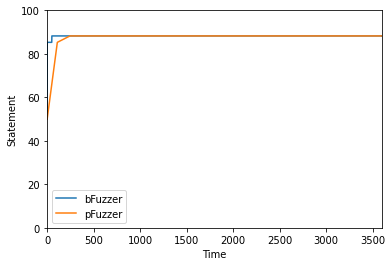

In [101]:
plt.plot(btinyc_time, btinyc_line, label='bFuzzer')
plt.plot(ptinyc_time, ptinyc_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
#plt.title('TinyC Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100]) 
plt.legend()
zoom(plt, 'tinyc-s')

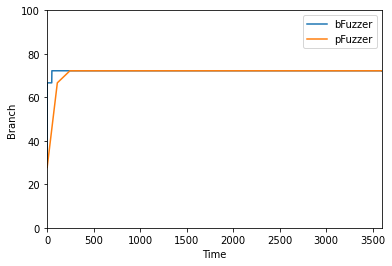

In [102]:
plt.plot(btinyc_time, btinyc_branch, label='bFuzzer')
plt.plot(ptinyc_time, ptinyc_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
#plt.title('TinyC Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'tinyc-b')

### Ini

In [104]:
bini_outputs, bini_time, bini_line, bini_branch = read_cov_data('data/bfuzzer_ini.json')

3600  line: 76.3 branch:  59.76


In [105]:
stats(bini_outputs)

Total:  4005
Unique:  3869
MaxLen:  216
MinLen:  4
Mean:  37.26389247867666


In [106]:
pini_outputs, pini_time, pini_line, pini_branch = read_cov_data('data/pfuzzer_ini.json')

3600  line: 75.56 branch:  56.1


In [107]:
stats(pini_outputs)

Total:  6
Unique:  6
MaxLen:  5
MinLen:  4
Mean:  4.666666666666667


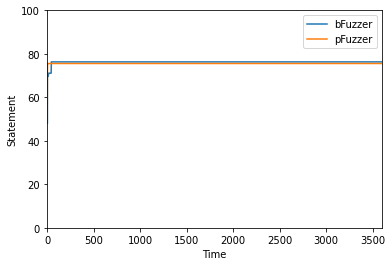

In [108]:
plt.plot(bini_time, bini_line, label='bFuzzer')
plt.plot(pini_time, pini_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
#plt.title('INI Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'ini-s')

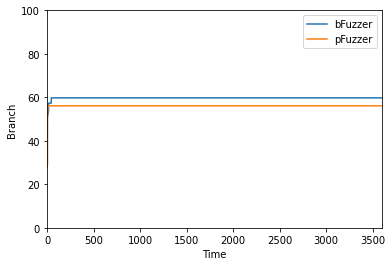

In [109]:
plt.plot(bini_time, bini_branch, label='bFuzzer')
plt.plot(pini_time, pini_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
#plt.title('INI Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100]) 
plt.legend()
zoom(plt, 'ini-b')

### CSV

In [139]:
bcsv_outputs, bcsv_time, bcsv_line, bcsv_branch = read_cov_data('data/bfuzzer_csv.json')

3600  line: 67.26 branch:  58.04


In [140]:
stats(bcsv_outputs)

Total:  252502
Unique:  132514
MaxLen:  18
MinLen:  5
Mean:  6.674192915465536


In [141]:
pcsv_outputs, pcsv_time, pcsv_line, pcsv_branch = read_cov_data('data/pfuzzer_csv.json')

3600  line: 67.26 branch:  58.04


In [142]:
stats(pcsv_outputs)

Total:  9
Unique:  9
MaxLen:  14
MinLen:  4
Mean:  6.888888888888889


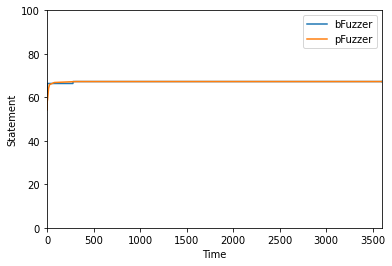

In [143]:
plt.plot(bcsv_time, bcsv_line, label='bFuzzer')
plt.plot(pcsv_time, pcsv_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
#plt.title('CSV Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'csv-s')

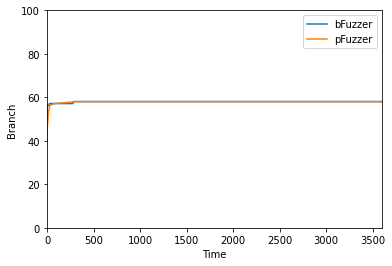

In [144]:
plt.plot(bcsv_time, bcsv_branch, label='bFuzzer')
plt.plot(pcsv_time, pcsv_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
#plt.title('CSV Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'csv-b')

### MJS

In [146]:
bmjs_outputs, bmjs_time, bmjs_line, bmjs_branch = read_cov_data('data/bfuzzer_mjs.json')

3600  line: 32.42 branch:  23.35


In [147]:
stats(bmjs_outputs)

Total:  49283
Unique:  32052
MaxLen:  959
MinLen:  4
Mean:  8.932827904654935


In [148]:
pmjs_outputs, pmjs_time, pmjs_line, pmjs_branch = read_cov_data('data/pfuzzer_mjs.json')

3600  line: 20.96 branch:  10.02


In [149]:
stats(pmjs_outputs)

Total:  8
Unique:  8
MaxLen:  13
MinLen:  4
Mean:  5.5


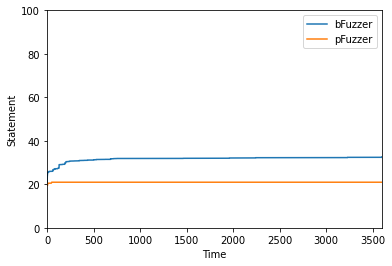

In [150]:
plt.plot(bmjs_time, bmjs_line, label='bFuzzer')
plt.plot(pmjs_time, pmjs_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
#plt.title('MJS Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'mjs-s')

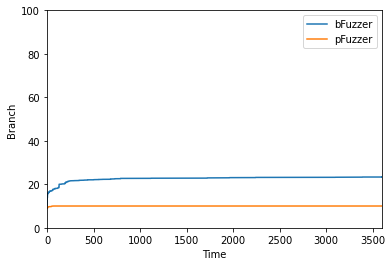

In [152]:
plt.plot(bmjs_time, bmjs_branch, label='bFuzzer')
plt.plot(pmjs_time, pmjs_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
#plt.title('MJS Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'mjs-b')

### CJSON

In [154]:
bcjson_outputs, bcjson_time, bcjson_line, bcjson_branch = read_cov_data('data/bfuzzer_cjson.json')

3600  line: 82.86 branch:  61.11


In [155]:
stats(bcjson_outputs)

Total:  2956
Unique:  2222
MaxLen:  431
MinLen:  5
Mean:  14.342484248424842


In [156]:
pcjson_outputs, pcjson_time, pcjson_line, pcjson_branch = read_cov_data('data/pfuzzer_cjson.json')

3600  line: 82.86 branch:  61.11


In [157]:
stats(pcjson_outputs)

Total:  13
Unique:  13
MaxLen:  12
MinLen:  4
Mean:  7.615384615384615


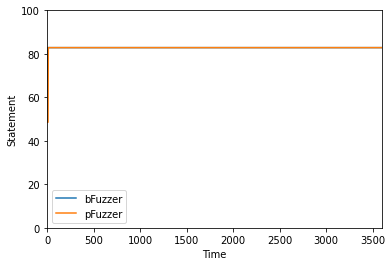

In [158]:
plt.plot(bcjson_time, bcjson_line, label='bFuzzer')
plt.plot(pcjson_time, pcjson_line, label='pFuzzer')
plt.ylabel('Statement')
plt.xlabel('Time')
#plt.title('CJSON Cumulative Statement Coverage')
plt.axis([0, 3600, 0, 100])
plt.legend()
zoom(plt, 'cjson-s')

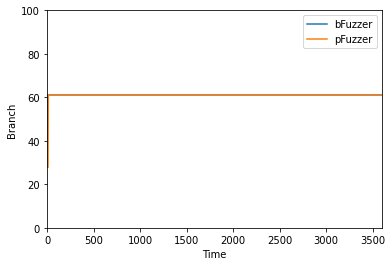

In [159]:
plt.plot(bcjson_time, bcjson_branch, label='bFuzzer')
plt.plot(pcjson_time, pcjson_branch, label='pFuzzer')
plt.ylabel('Branch')
plt.xlabel('Time')
#plt.title('CJSON Cumulative Branch Coverage')
plt.axis([0, 3600, 0, 100]) 
plt.legend()
zoom(plt, 'cjson-b')